**Importing Modules**

In [ ]:
import numpy as np
import pandas as pd
import random
import csv
import requests
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

**Lowrank Function**<br>
Function to calculate the low rank approximation of the input matrix.

In [ ]:
def lowrank(U,S,V,k):
  UR = U[:, :k]
  SR = np.diag(S[:k])
  VR = V[:k, :]
  result = np.dot(np.dot(UR,SR), VR)

  return result

**Importing Ratings Data**<br>
The ratings data is imported and the aggregate ratings for each movie and user are stored as an array in separate dictionaries.

In [ ]:
uniq_movId = {}
count = 0
rating = []
movie_avg = {}
user_avg = {}

url = 'https://raw.githubusercontent.com/kushagra-18110091/http_test/main/ratings_small.csv'
ratings = requests.get(url, allow_redirects=True)
open('ratings.csv', 'wb').write(ratings.content)

file = open('ratings.csv', 'r')
CSVFile = csv.reader(file)
next(CSVFile, None)
userId = 1

for row in CSVFile:
    if(row[0] not in user_avg):
        user_avg[row[0]] = [float(row[2]),1]
    else :
        user_avg[row[0]][0] += float(row[2])
        user_avg[row[0]][1] += 1

    userId = max(userId,int(row[0]))
    if(row[1] not in uniq_movId):
        uniq_movId[row[1]] = count 
        count += 1
        movie_avg[row[1]] = [float(row[2]),1]
    else:
        movie_avg[row[1]][0] += float(row[2])
        movie_avg[row[1]][1] += 1

    rating.append(row[:-1]) 


**Creating Test and Train Data**<br>
The test and training data are create from the rating array and all non present entries are replaced by 2.5 assuming that ratings are between 1-5.

In [ ]:
rows, cols = (userId+1, len(uniq_movId))
rating_array =  [[2.5]*(cols) for i in range(rows)]

random.shuffle(rating)
train = rating[len(rating)//5 :]
test = rating[: len(rating)//5]

for i in range(len(train)):
  rating_array[int(train[i][0])][int(uniq_movId[train[i][1]])] = float(train[i][2])


**Calculating SVD**<br>
The SVD for the rating array is calculated and stored in U, S and V matrices.

In [ ]:
U, S, V = np.linalg.svd(rating_array, full_matrices=False)

**Calculating Low Rank Approximation**<br>
The low rank approximation of the matrix is calculated using U, S and V matrices calculated above. The squared error for each entry is then calculated using the test data. 

In [ ]:
lowrank_error = []

for k in range(1,100):
  rating_lowrank = lowrank(U,S,V,k)
  error = 0
  for i in range(len(test)):
    error += (float(test[i][2]) - rating_lowrank[int(test[i][0])][int(uniq_movId[test[i][1]])]) ** 2

  lowrank_error.append(error)

print(lowrank_error)

[36280.54908803819, 33443.92557016882, 32312.86795361154, 31601.034609112237, 31423.618939958553, 31412.29257847922, 31330.45919243365, 31056.94095263504, 31002.564698731425, 30912.140209561072, 30975.77180374384, 31012.16233363711, 31098.733327982976, 31161.0255754459, 31183.528029484325, 31304.11804753768, 31436.704276727633, 31479.426927708624, 31557.016924568867, 31620.59774063933, 31689.825449631808, 31774.645903377383, 31828.150231115655, 31922.75307301092, 31983.079331865592, 32035.21853387761, 32099.074889659125, 32143.87204579086, 32208.846305528295, 32276.95805362152, 32356.638838121457, 32433.801595751556, 32516.802821418776, 32626.3652763992, 32680.161118102616, 32825.48223034625, 32902.695223682655, 32989.51980274846, 33044.76271683718, 33105.26491259393, 33217.31528045608, 33329.472802816934, 33423.66996847748, 33513.17057172596, 33562.54614153261, 33643.470200334654, 33740.24840741875, 33809.47756175662, 33864.06740071913, 33936.886694751316, 34003.94350514147, 34093.549

**Calculating Average User and Movie Rating**<br>
The average user and movie ratings are calculated using the dictionaries created in the first step.

In [ ]:
ui = []
nj = []
matrix = []

for i in range(len(test)):
  ui.append(user_avg[test[i][0]][0]/user_avg[test[i][0]][1])
  nj.append(movie_avg[test[i][1]][0]/movie_avg[test[i][1]][1])
  matrix.append((float(test[i][2])))

**Calculating Base Line Error**<br>
The base line error is calculated using the baseline algorithm.

In [ ]:
base_error = 0

def func_obj(X, a, b):
    ui,nj = X
    return a*ui+b*nj

fit = curve_fit(func_obj, (ui,nj), matrix)
alpha = fit[0][0]
beta = fit[0][1]

for i in range(len(test)):
  base_error += ((alpha*ui[i] + beta*nj[i]) - float(test[i][2]))**2

print(base_error)

14131.499102815249


**Plotting the results**<br>
The errors calculated using the test data and the base line error are plotted.

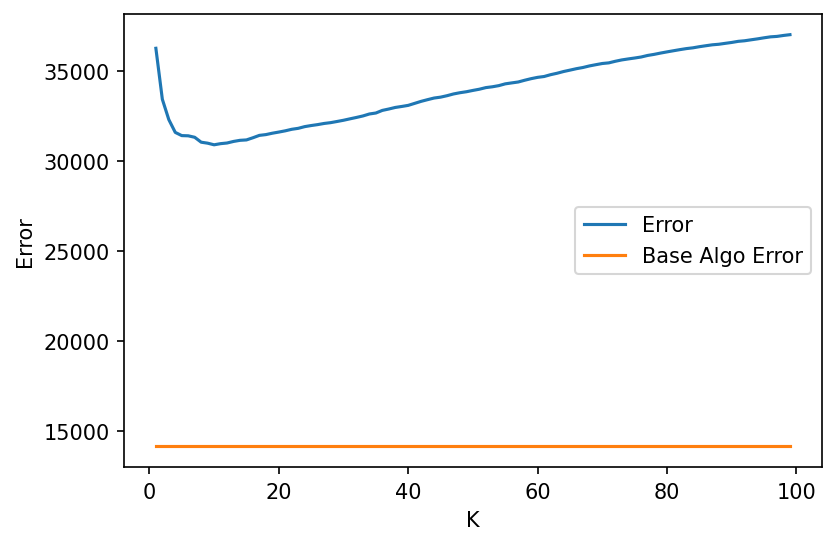

In [ ]:
x = []
y = []
for k in range(1,100):
  x.append(k)
  y.append(base_error)
  
plt.figure(dpi=150)  
plt.plot(x, lowrank_error, label = "Error")
plt.plot(x, y, label = "Base Algo Error")
  
plt.xlabel('K')
plt.ylabel('Error')
  
plt.legend()
  
plt.show()